<a href="https://colab.research.google.com/github/AadityaAdh/Traffic_sign_recognition/blob/main/Trafficsigndetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import cv2
import json
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_images=tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/train/images/*.png',shuffle=False)

In [ ]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
val_images=tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/valid/images/*.png',shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)


In [ ]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/train/labels/*.json', shuffle=False)

In [ ]:
def load_labels(x):
    label_file = x.numpy().decode("utf-8")
    with open(label_file, "r") as f:
        my_json_object = json.load(f)
        label = my_json_object["class"].lower()
        if label == "st_or_right":
            return tf.constant([1, 0, 0], dtype=tf.float32)
        elif label == "straight":
            return tf.constant([0, 1, 0], dtype=tf.float32)
        else:
            return tf.constant([0, 0, 1], dtype=tf.float32)


In [ ]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/train/labels/*.json', shuffle=False)
train_labels=train_labels.map(lambda x :tf.py_function(load_labels,[x],tf.float32))

In [ ]:
for elements in train_labels.take(1):
    print(elements)

tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


In [ ]:
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data/valid/labels/*.json', shuffle=False)
val_labels=val_labels.map(lambda x :tf.py_function(load_labels,[x],tf.float32))

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(8)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(8)

<class 'tuple'>
tf.Tensor(
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]], shape=(16, 3), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


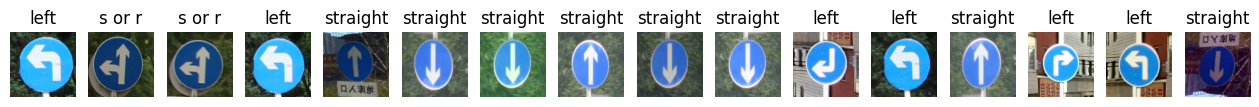

In [ ]:
import numpy as np

plt.figure(figsize=(16, 4))
for element in train.take(1):
    print(type(element))
    print(element[1])
    print(element[1][0])
    #element [0] vitra 8 oota image xan
    #aani element[1] vitra 8 labels xan
    #print(element[0][0])
    #print(type(element[0]))
    #prefetch le garda ho ki jati choti run garayo tei change vai rado raixa
    for i, (my_image, label) in enumerate(zip(element[0], element[1])):
        plt.subplot(1, 16, i + 1)  # Create subplots for each image
        plt.imshow(my_image)
        if np.array_equal(label, [1.0, 0.0, 0.0]):
            plt.title("s or r")
        elif np.array_equal(label, [0, 1, 0]):
            plt.title("straight")
        else:
            plt.title("left")
        plt.axis('off')  # Turn off axis
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,InputLayer,BatchNormalization,Dropout

In [ ]:
model=tf.keras.Sequential([
    InputLayer(input_shape=(120,120,3)),
    Conv2D(filters=60,kernel_size=5,strides=1,padding="valid",activation="relu"),
    Conv2D(filters=60,kernel_size=5,strides=1,padding="valid",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),


    Conv2D(filters=60,kernel_size=5,strides=1,padding="valid",activation="relu"),
    Conv2D(filters=60,kernel_size=5,strides=1,padding="valid",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),







    Flatten(),



    Dense(500,activation="relu"),


    Dense(3,activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 116, 116, 60)      4560      
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 60)      90060     
                                                                 
 batch_normalization (Batch  (None, 112, 112, 60)      240       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 60)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 60)        90060     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 60)        9

In [ ]:
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy




In [ ]:
model.compile(optimizer=legacy.Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=[Accuracy()])

In [ ]:
history=model.fit(train,validation_data=val,epochs=100,verbose=1)

Epoch 1/100
195/195 [==============================] - 61s 231ms/step - loss: 13.0827 - accuracy: 0.4504 - val_loss: 14.2377 - val_accuracy: 0.4101
Epoch 2/100
195/195 [==============================] - 54s 204ms/step - loss: 13.0701 - accuracy: 0.4583 - val_loss: 13.6442 - val_accuracy: 0.4328
Epoch 3/100
195/195 [==============================] - 55s 206ms/step - loss: 9.0359 - accuracy: 0.6248 - val_loss: 9.5854 - val_accuracy: 0.5992
Epoch 4/100
195/195 [==============================] - 55s 206ms/step - loss: 8.7100 - accuracy: 0.6389 - val_loss: 9.5610 - val_accuracy: 0.6040
Epoch 5/100
195/195 [==============================] - 55s 206ms/step - loss: 8.7410 - accuracy: 0.6382 - val_loss: 9.5610 - val_accuracy: 0.6043
Epoch 6/100
195/195 [==============================] - 54s 205ms/step - loss: 8.6480 - accuracy: 0.6417 - val_loss: 9.5732 - val_accuracy: 0.6035
Epoch 7/100
195/195 [==============================] - 54s 205ms/step - loss: 8.5447 - accuracy: 0.6464 - val_loss: 9.57

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,InputLayer,BatchNormalization


model1=tf.keras.Sequential([
    InputLayer(input_shape=(120,120,3)),
    Conv2D(filters=60,kernel_size=5,strides=1,padding="valid",activation="relu"),
    BatchNormalization(),
    Conv2D(filters=60,kernel_size=5,strides=1,padding="valid",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),


    Conv2D(filters=60,kernel_size=5,strides=1,padding="valid",activation="relu"),
    BatchNormalization(),
    Conv2D(filters=60,kernel_size=5,strides=1,padding="valid",activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),







    Flatten(),



    Dense(128,activation="relu"),


    Dense(3,activation="softmax")
])


model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 116, 116, 60)      4560      
                                                                 
 batch_normalization_4 (Bat  (None, 116, 116, 60)      240       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 60)      90060     
                                                                 
 batch_normalization_5 (Bat  (None, 112, 112, 60)      240       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 60)        0         
 g2D)                                                            
                                                      

In [ ]:
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy




In [ ]:
model1.compile(optimizer=legacy.Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=[Accuracy()])

In [ ]:
import numpy as np

In [ ]:
model1.predict(np.ones((1,120,120,3), dtype=np.float32)
)

1/1 [==============================] - 0s 108ms/step


array([[0.3562843 , 0.31651616, 0.32719952]], dtype=float32)

In [ ]:
history=model1.fit(train,validation_data=val,epochs=100,verbose=1)

Epoch 1/100
68/68 [==============================] - 19s 179ms/step - loss: 2.9613 - accuracy: 0.6895 - val_loss: 7.6157 - val_accuracy: 0.5535
Epoch 2/100
68/68 [==============================] - 18s 167ms/step - loss: 1.5573 - accuracy: 0.8404 - val_loss: 11.7222 - val_accuracy: 0.5152
Epoch 3/100
68/68 [==============================] - 17s 171ms/step - loss: 0.8822 - accuracy: 0.8914 - val_loss: 11.7222 - val_accuracy: 0.5078
Epoch 4/100
68/68 [==============================] - 17s 162ms/step - loss: 2.1722 - accuracy: 0.8636 - val_loss: 2.2564 - val_accuracy: 0.8664
Epoch 5/100
68/68 [==============================] - 18s 163ms/step - loss: 0.8138 - accuracy: 0.9469 - val_loss: 3.5774 - val_accuracy: 0.8283
Epoch 6/100
68/68 [==============================] - 19s 191ms/step - loss: 0.4459 - accuracy: 0.9667 - val_loss: 2.2856 - val_accuracy: 0.8386
Epoch 7/100
68/68 [==============================] - 17s 158ms/step - loss: 0.6715 - accuracy: 0.9432 - val_loss: 2.8740 - val_accurac

In [ ]:
model1.save('/content/drive/MyDrive/model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model1.save('/content/drive/My Drive/model2.keras')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
#model.save('/content/drive/MyDrive/model.h5')

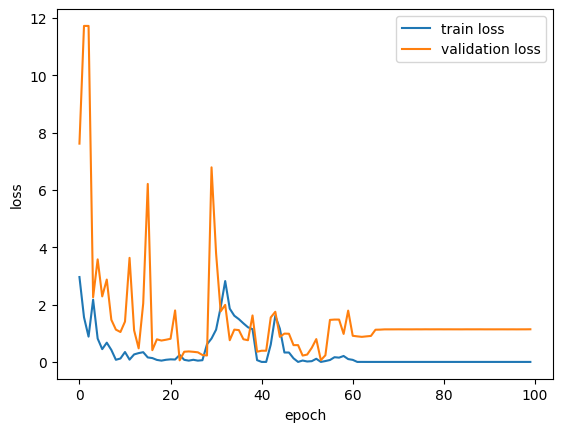

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


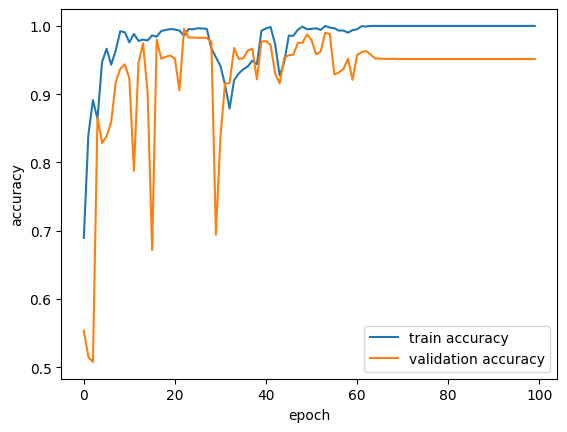

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train accuracy','validation accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()


In [ ]:
test_img=cv2.imread('/content/drive/MyDrive/aug_data/valid/images/020_1_0005.22.png')

In [ ]:
rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
resized = tf.image.resize(rgb, (120,120))

yhat = model1.predict(np.expand_dims(resized/255,0))

1/1 [==============================] - 0s 17ms/step


In [ ]:
yhat

array([[1., 0., 0.]], dtype=float32)